In [40]:
!pip install XGBoost
!pip install LGBM

ERROR: Could not find a version that satisfies the requirement LGBM (from versions: none)
ERROR: No matching distribution found for LGBM


In [41]:
# 머신러닝 모델링에 필요한 파이썬 라이브러리와 싸이킷런 패키지를 호출합니다.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

sns.set()

In [42]:
df = pd.read_csv("regression_dataset.csv")

In [43]:
df.head(3)

,Unnamed: 0,order_status,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_state,seller_state,customer_lat,...,seller_lng,distance_customer_seller_km,product_volume_cm3,purchase_dayofweek,purchase_hour,purchase_month,is_weekend,shipping_duration_days,is_late,estimated_duration_days
0,0,delivered,8.72,1,credit_card,1,18.12,SP,SP,-23.576983,...,-46.444238,18.576135,1976.0,0,10,10,0,2,0,8
1,1,delivered,8.72,3,voucher,1,2.00,SP,SP,-23.576983,...,-46.444238,18.576135,1976.0,0,10,10,0,2,0,8
2,2,delivered,8.72,2,voucher,1,18.59,SP,SP,-23.576983,...,-46.444238,18.576135,1976.0,0,10,10,0,2,0,8


In [44]:
# payment_sequential은 1이 95.6%를 차지해 학습에 유효하게 사용될 수 없기에 제거합니다.
# 파생변수인 구매자, 판매자 간 거리를 구했으니 위도와 경도는 제거합니다.
# 구매자, 배송자 거주지(state)는 거리 파생 변수가 있기에 제거 합니다.
# order_status와 is_late는 배송하는 회사 입장에서는 미리 아는 정보이기 때문에 현실적이지 않고, 데이터 누수가 발생하기에 제거합니다.

df.drop(['payment_sequential', 'customer_state', 'seller_state', 'customer_lat', 'customer_lng', 'seller_lat', 'seller_lng', 'order_status', 'Unnamed: 0', 'is_late'], axis=1, inplace=True)

In [45]:
df.head(3)

,freight_value,payment_type,payment_installments,payment_value,distance_customer_seller_km,product_volume_cm3,purchase_dayofweek,purchase_hour,purchase_month,is_weekend,shipping_duration_days,estimated_duration_days
0,8.72,credit_card,1,18.12,18.576135,1976.0,0,10,10,0,2,8
1,8.72,voucher,1,2.00,18.576135,1976.0,0,10,10,0,2,8
2,8.72,voucher,1,18.59,18.576135,1976.0,0,10,10,0,2,8


In [46]:
# target 변수의 분포를 확인합니다.
df['estimated_duration_days'].value_counts().reset_index()

,estimated_duration_days,count
0,7,8937
1,6,7985
2,8,7909
3,9,7073
4,5,6850
...,...,...
141,109,1
142,189,1
143,173,1
144,133,1


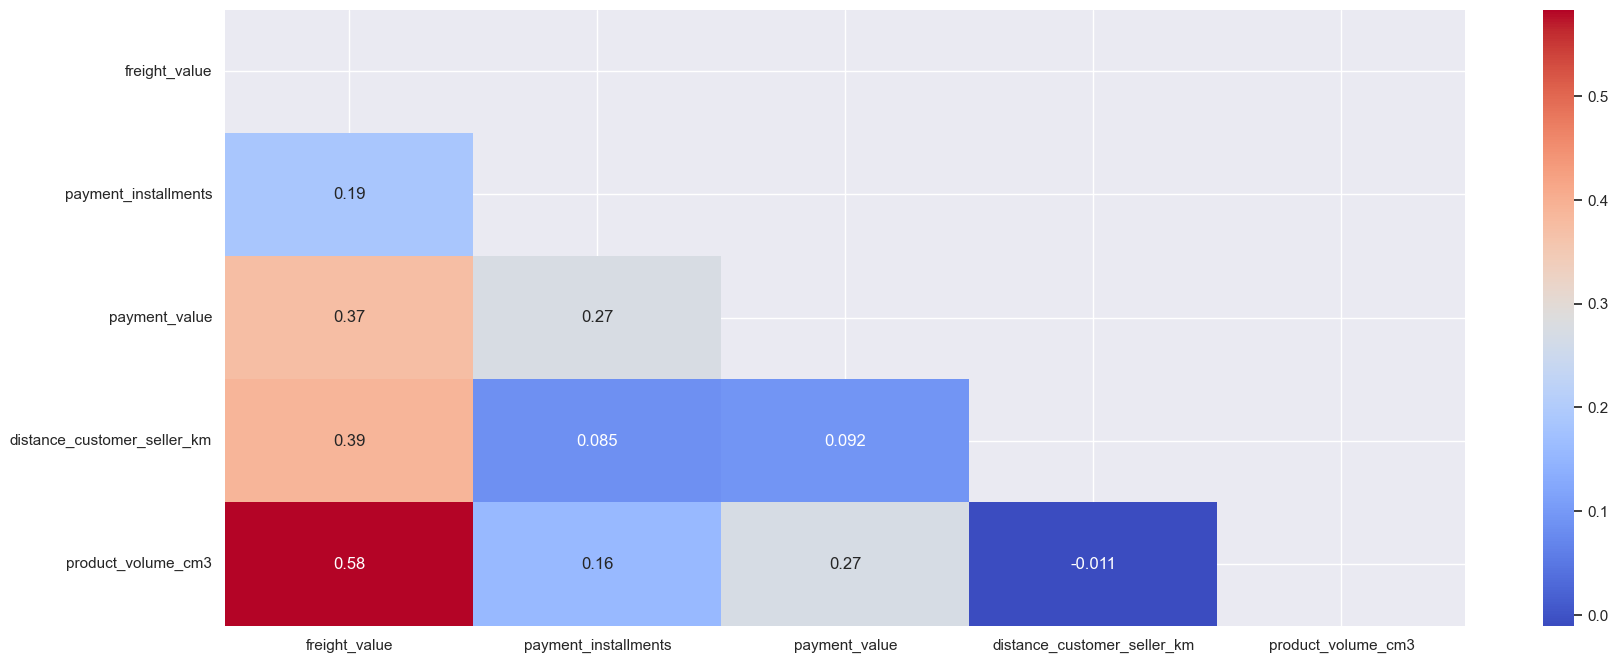

In [47]:
# 수치형 변수 간 상관관계를 확인합니다.
tmp = df[['freight_value', 'payment_installments', 'payment_value', 'distance_customer_seller_km', 'product_volume_cm3']]
tmp_corr = tmp.corr()
mask = np.triu(np.ones_like(tmp_corr, dtype=bool)) # 마스크를 생성해서 중복되는 부분은 없애줍니다.

plt.figure(figsize=(20, 8))
sns.heatmap(
    data = tmp_corr,
    cmap = 'coolwarm',
    annot = True,
    mask = mask
)
plt.show()

## LinearRegression

In [48]:
# 선형회귀 모델의 안정적인 학습을 위해 수치형 변수들을 표준 정규분포로 만듭니다.

num_cols = ['freight_value', 'payment_value', 'distance_customer_seller_km', 'product_volume_cm3']

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols)
    ]
)

In [49]:
# 데이터 누수를 막기 위해 pipeline을 생성합니다.

pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

In [50]:
# 효율적인 학습과 우수한 성능을 위해 payment_type 카테고리 변수를 제거합니다.

X = df[["freight_value", "payment_value", "distance_customer_seller_km",
              "product_volume_cm3", 'purchase_dayofweek', 'purchase_hour',
              "purchase_month", "is_weekend", "shipping_duration_days"]] # 수치형 변수만 학습에 사용합니다.
y = df["estimated_duration_days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 데이터를 분할합니다.

In [51]:
# 모델을 학습시킵니다.
model = pipeline.fit(X_train, y_train)

In [52]:
# 학습한 모델로 예측값을 구합니다.
lr_pred = model.predict(X_test)

In [53]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print("r2 score: ", r2_score(y_test, lr_pred))
print("mae: ", mean_squared_error(y_test, lr_pred))

r2 score:  0.16602691164958028
mae:  73.61315202195604


## Lidge 회귀

In [54]:
# 학습에 사용할 파이프라인을 구합니다.
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', Lasso())
    ]
)

In [55]:
# 모델을 학습시킵니다.
model = pipeline.fit(X_train, y_train)

In [56]:
# 학습한 모델로 예측값을 만듭니다.
lasso_pred = model.predict(X_test)

In [57]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print("r2 score: ", r2_score(y_test, lr_pred))
print("mae: ", mean_squared_error(y_test, lr_pred))

r2 score:  0.16602691164958028
mae:  73.61315202195604


## Ridge

In [58]:
pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', Ridge())
    ]
)

In [59]:
model = pipeline.fit(X_train, y_train)

In [60]:
ridge_pred = model.predict(X_test)

In [61]:
# 회귀 모델의 성능을 확인할 수 있는 r2(설명력)와 mae(오차)를 구합니다.

print('r2 score: ',r2_score(y_test, ridge_pred))
print('mae: ', mean_squared_error(y_test, ridge_pred))

r2 score:  0.1660268910965087
mae:  73.61315383613494


## RandomForestRegressor

In [62]:
rfr_pipeline = Pipeline(
    steps = [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]
)

In [63]:
# gridsearch cv로 실험에 사용할 하이퍼 파라미터 조합을 지정합니다.
param_gird = {
    'model__n_estimators':[100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

In [64]:
# 그리드 서치로 모델을 학습시키고, 최적의 하이퍼 파라미터 조합을 찾습니다.
rfr_grid = GridSearchCV(
    estimator = rfr_pipeline, # 학습에 사용할 모델을 지정합니다.
    param_grid = param_gird, # 실험에 사용할 파라미터 조합을 지정합니다.
    cv = 5, # 검증 횟수를 구합니다.
    n_jobs = -1, # gpu 사용 여부를 지정합니다. (-1: 사용하지 않음)
    verbose = 2 # 구체적인 학습 과정을 보여줍니다. (0: 학습 표시 x, 1: 대략적인 학습 표시, 2: 구체적인 학습 표시)
)

In [65]:
rfr_grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__max_depth': [10, 20, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...], 'model__n_estimators': [100, 200, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [66]:
rfr_pred = rfr_grid.predict(X_test)

In [67]:
print("r2 score: ", r2_score(y_test, rfr_pred))
print("mse score: ", mean_squared_error(y_test, rfr_pred))

r2 score:  0.2866707033645347
mse score:  62.9641635784746


## XGBoost

In [68]:
X = df[["freight_value", "payment_value", "distance_customer_seller_km",
              "product_volume_cm3", 'purchase_dayofweek', 'purchase_hour',
              "purchase_month", "is_weekend", "shipping_duration_days"]]
y = df["estimated_duration_days"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [69]:
xgb_pipeline = Pipeline(
    steps = [
        ('regressor', XGBRegressor(random_state=42))
    ]
)

In [70]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__subsample': [0.8, 1.0]
}
# scoring으로 모델 성능 평가 기준을 지정합니다.
scoring = ['neg_mean_squared_error', 'r2']

In [71]:
xgb_grid = GridSearchCV(
    estimator = xgb_pipeline,
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 2,
    scoring = scoring,
    refit = 'r2' # r2를 기준으로 모델을 평가합니다.
)

In [72]:
xgb_grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


C:\Users\lizzy\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__colsample_bytree': [0.6, 0.8, ...], 'regressor__learning_rate': [0.01, 0.05, ...], 'regressor__max_depth': [3, 5, ...], 'regressor__n_estimators': [100, 200, ...], ...}"
,scoring,"['neg_mean_squared_error', 'r2']"
,n_jobs,-1
,refit,'r2'
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [73]:
xgb_pred = xgb_grid.predict(X_test)

In [74]:
print("r2 score: ", r2_score(y_test, xgb_pred))
print("mse score: ", mean_squared_error(y_test, xgb_pred))
print("mape: ", mean_absolute_percentage_error(y_test, xgb_pred))

r2 score:  0.4238322973251343
mse score:  50.857181549072266
mape:  7278600126464.0


## LGBM

In [75]:
lgbm_pipeline = Pipeline(
    steps = [
        ('model', LGBMRegressor(random_state=42))
    ]
)

In [76]:
param_grid = {
    'model__n_estimators': [500, 1000, 2000],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__num_leaves': [31, 63, 127],
    'model__max_depth': [6, 8, 10],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

scoring = ['neg_mean_squared_error', 'r2']

In [77]:
lgbm_grid = GridSearchCV(
    estimator = lgbm_pipeline,
    param_grid = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 2,
    scoring = scoring,
    refit = 'r2'
)

In [79]:
lgbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


KeyboardInterrupt: 

In [ ]:
lgbm_pred = lgbm_grid.predict(X_test)

In [ ]:
print('r2 score: ', r2_score(y_test, lgbm_pred))
print('mse score: ', mean_squared_error(y_test, lgbm_pred))